In [0]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # for showing pictures
%matplotlib inline

CNN Parameters: 
- ConvLayer: kernel_size, out_channels (number of filters), stride, padding
- PoolLayer: kernel_size, stride, pool_type, padding

MNIST = 70k pictures: 10k of test dataset and 60k of train dataset.

###Loading Data

In [0]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4, 
                                          shuffle=True, 
                                          num_workers=2) 

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True, 
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False, 
                                         num_workers=2)

classes = tuple(str(i) for i in range(10))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


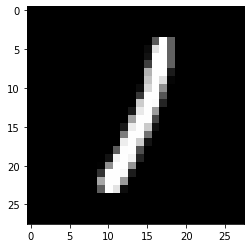

In [14]:
#See random image:
i = np.random.randint(low=0, high=60000)
plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

### Building the model (as Pytorch Functional)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Class is inherited from nn.Module !
class SimpleConvNet(nn.Module):
    def __init__(self):
        
        super(SimpleConvNet, self).__init__() # constructor inheritance

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # data shape
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape) 
        x = x.view(-1, 4 * 4 * 16)  # data shape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Model Training

In [0]:
from tqdm import tqdm_notebook
net = SimpleConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

[1,  2000] loss: 1.020
[1,  4000] loss: 0.394
[1,  6000] loss: 0.305
[1,  8000] loss: 0.249
[1, 10000] loss: 0.219
[1, 12000] loss: 0.191
[1, 14000] loss: 0.174


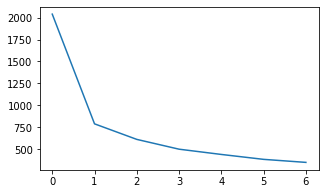

[2,  2000] loss: 0.145
[2,  4000] loss: 0.143
[2,  6000] loss: 0.131
[2,  8000] loss: 0.123
[2, 10000] loss: 0.121
[2, 12000] loss: 0.105
[2, 14000] loss: 0.107


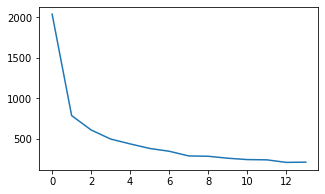


Training has finished


In [18]:
for epoch in tqdm_notebook(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # get current batch
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        # forward, backward, optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # current loss
        running_loss += loss.item()

        # accuracy every 2000 batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    plt.figure(figsize=(5,3))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Training has finished')

###Model Testing

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
mistakes = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            if c[i] == 0:
                mistakes.append([data[0][i], data[1][i], predicted[i]])

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 93 %
Accuracy of     6 : 97 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 96 %


The prediction is: 5


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


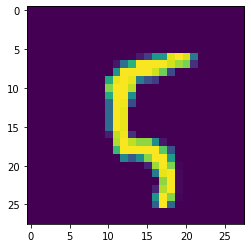

In [20]:
def CheckImg(i):
    image = trainloader.dataset.test_data[i]
    plt.imshow(image.numpy())
    image = image.view(1, 1, 28, 28).type('torch.FloatTensor')
    print('The prediction is:', torch.argmax(net(image)).item())

CheckImg(100)

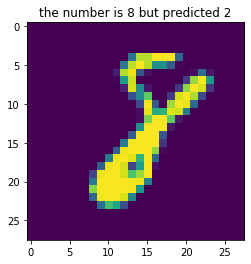

In [21]:
def ShowMistake(i):
    img = mistakes[i][0][0]
    plt.figure()
    plt.plot()
    plt.imshow(img.numpy())
    plt.title('the number is '+str(mistakes[i][1].item())+' but predicted '+str(mistakes[i][2].item()))

ShowMistake(100)